In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e219baf8a107e3cf8a22415635fa6d5d2480d31bc99a59edb0b6dd219680aa88
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=56110d9b63ef2ea1a718f0ab860776c91fd6110e29ed6773e74326f9994c69aa
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534

Train Set Samples:
Number of Train Samples: 431
Number of Train Masks: 431

Validation Set Samples:
Number of Validation Samples: 61
Number of Validation Masks: 61

Test Set Samples:
Number of Test Samples: 124
Number of Test Masks: 124


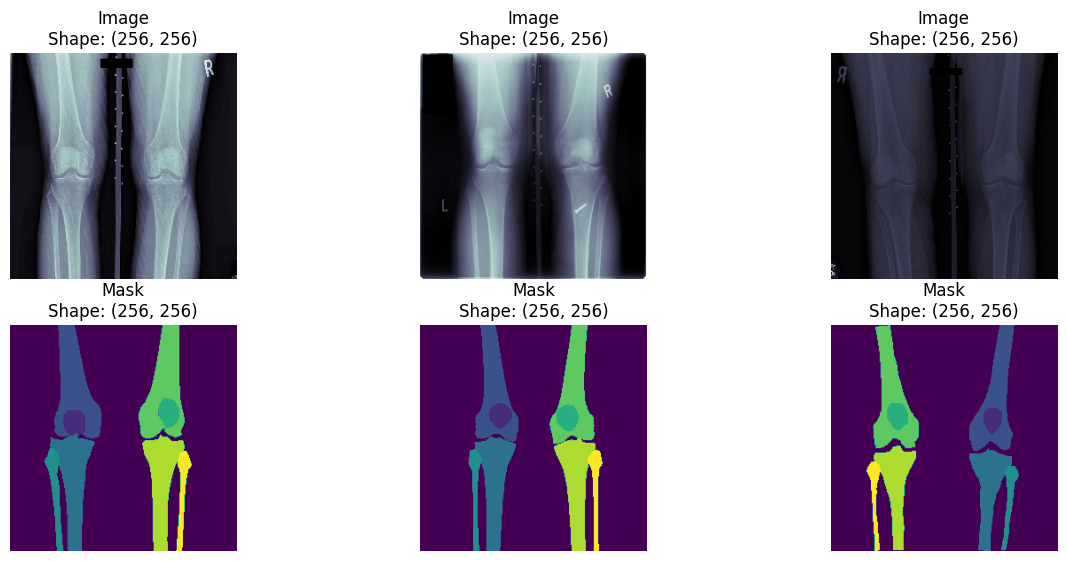

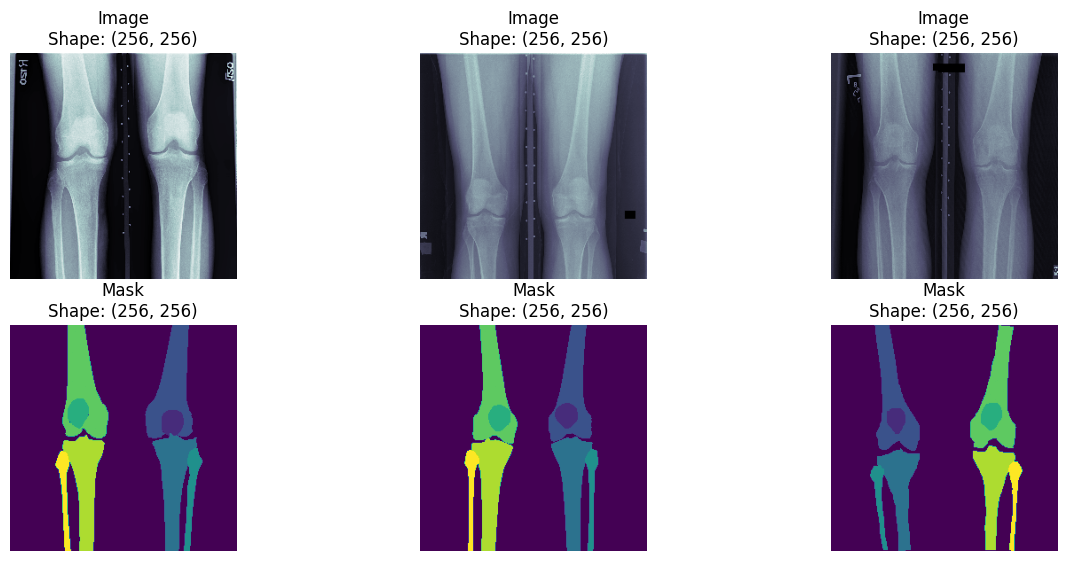

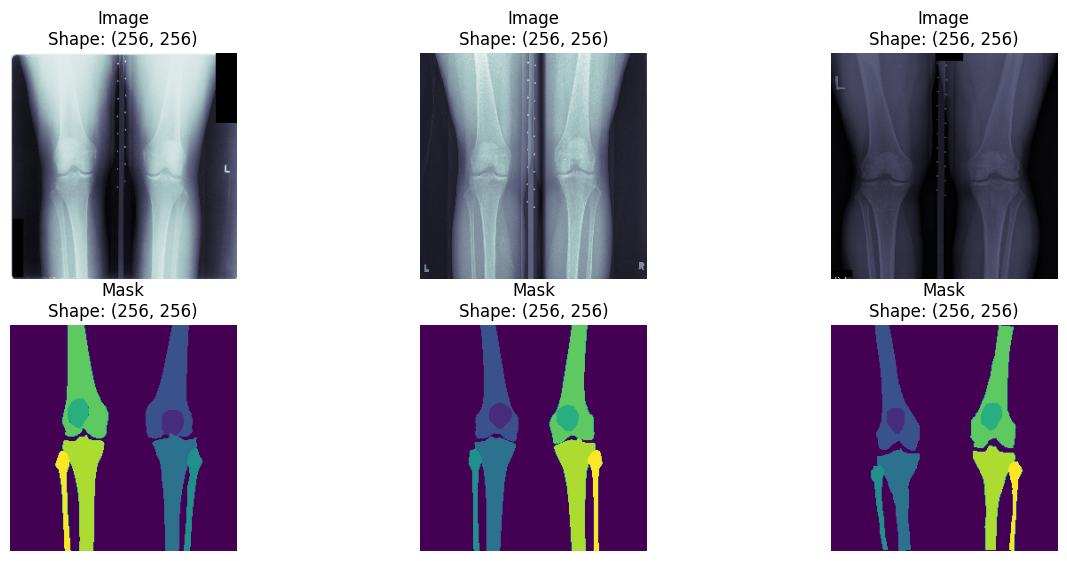

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

class KneeSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        # Resize annotation to match image dimensions
        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        # Add channel dimension to mask if not already there
        if annotation_data.ndim == 2:
            annotation_data = np.expand_dims(annotation_data, axis=0)

        annotation_data = torch.from_numpy(annotation_data).float()

        # Apply preprocessing
        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        return image, annotation_data

img_root = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Images"
mask_root = "JHIR_Hip_Knee_Datasets/JHIR_Hip_Knee_Datasets/Knee/Annotations"

# Create a dataset
image_files = os.listdir(img_root)[:650]
mask_files = os.listdir(mask_root)[:650]

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

train_size = int(0.7 * len(image_files))
valid_size = int(0.1 * len(image_files))
test_size = len(image_files) - train_size - valid_size

train_files = image_files[:train_size]
valid_files = image_files[train_size:train_size + valid_size]
test_files = image_files[train_size + valid_size:]

train_set = KneeSegmentationDataset(img_root, mask_root, train_files, mask_files, transforms=augmentations, preprocessing=None)
valid_set = KneeSegmentationDataset(img_root, mask_root, valid_files, mask_files, transforms=augmentations, preprocessing=None)
test_set = KneeSegmentationDataset(img_root, mask_root, test_files, mask_files, transforms=augmentations, preprocessing=None)

def visualize_samples(dataset, num_samples=3, img_cmap='bone', mask_cmap='viridis'):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        image, mask = dataset[i]
        image_np = image.squeeze().numpy()
        mask_np = mask.squeeze().numpy()

        plt.subplot(3, num_samples, i + 1)
        plt.imshow(image_np, cmap=img_cmap)
        plt.axis('off')
        plt.title(f'Image\nShape: {image_np.shape}')

        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(mask_np, cmap=mask_cmap)
        plt.axis('off')
        plt.title(f'Mask\nShape: {mask_np.shape}')

print("Train Set Samples:")
visualize_samples(train_set, num_samples=3)
print("Number of Train Samples:", len(train_set))
print("Number of Train Masks:", len(train_set))

print("\nValidation Set Samples:")
visualize_samples(valid_set, num_samples=3)
print("Number of Validation Samples:", len(valid_set))
print("Number of Validation Masks:", len(valid_set))

print("\nTest Set Samples:")
visualize_samples(test_set, num_samples=3)
print("Number of Test Samples:", len(test_set))
print("Number of Test Masks:", len(test_set))

plt.show()


In [ ]:
pip install segmentation-models-pytorch


Epoch 1/25, Training Loss: 0.7715904414653778, Training IoU: 0.34085877819193733, Training F-score: 0.5045227805773417
Epoch 1/25, Validation Loss: 0.7791083782911301, Validation IoU: 0.4051215350627899, Validation F-score: 0.5745099797844887
Epoch 2/25, Training Loss: 0.7550543016857572, Training IoU: 0.47126252783669365, Training F-score: 0.6402457058429718
Epoch 2/25, Validation Loss: 0.7631076037883758, Validation IoU: 0.4756528913974762, Validation F-score: 0.6416172325611115
Epoch 3/25, Training Loss: 0.7479748792118497, Training IoU: 0.5008006128999922, Training F-score: 0.6667616764704386
Epoch 3/25, Validation Loss: 0.7582199901342392, Validation IoU: 0.49708002358675, Validation F-score: 0.6613501220941543
Epoch 4/25, Training Loss: 0.744307816028595, Training IoU: 0.5240156915452745, Training F-score: 0.6872675749990675
Epoch 4/25, Validation Loss: 0.7548971921205521, Validation IoU: 0.5172305643558502, Validation F-score: 0.6792964845895767
Epoch 5/25, Training Loss: 0.7410

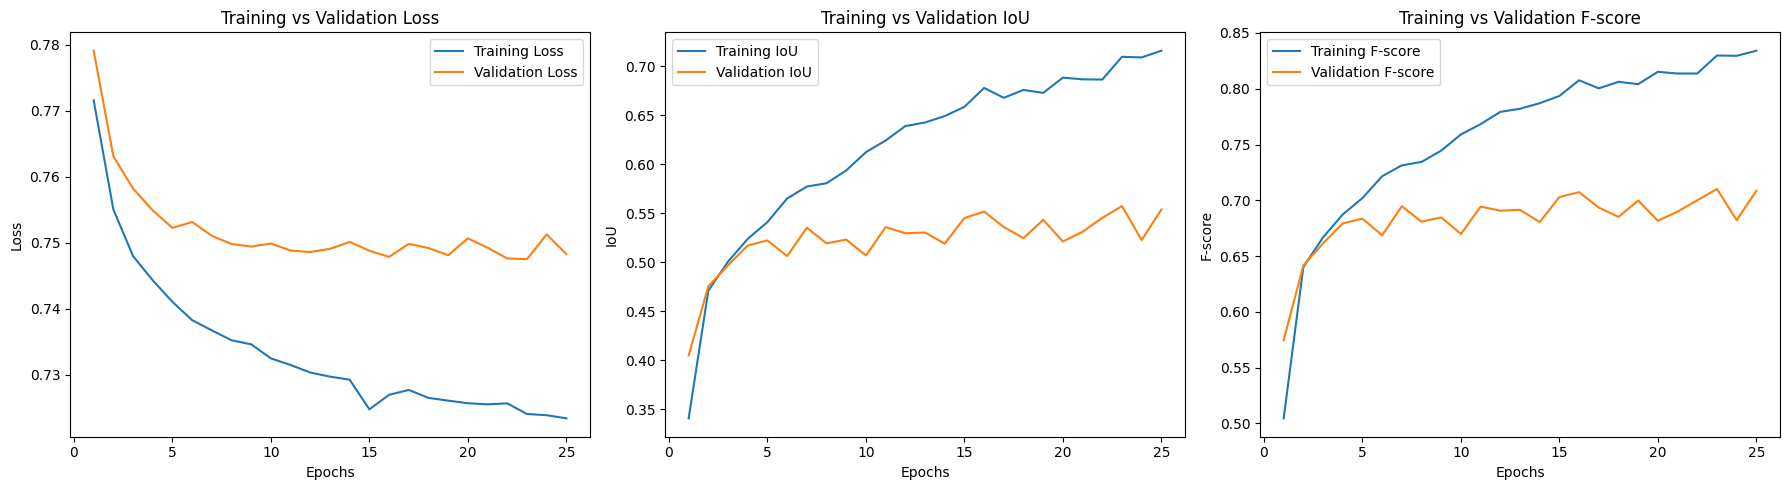

In [ ]:
import segmentation_models_pytorch as smp
import torch.optim as optim
from torch.utils.data import DataLoader
from segmentation_models_pytorch import utils as smp_utils
import matplotlib.pyplot as plt
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)
iou_metric = smp_utils.metrics.IoU(threshold=0.5)
fscore_metric = smp.utils.metrics.Fscore(threshold=0.5)
loss_function = smp.losses.JaccardLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False, num_workers=1)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=1)

train_losses = []
valid_losses = []
train_ious = []
valid_ious = []
train_fscores, valid_fscores = [], []
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    train_epoch_loss, train_epoch_iou, train_epoch_fscore = 0, 0, 0
    for batch in train_loader:
        images, masks = batch
        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        masks = masks.to(outputs.dtype)
        outputs = torch.clamp(outputs, 0, 1)
        masks = torch.clamp(masks, 0, 1)
        loss_value = loss_function(outputs, masks)
        loss_value.backward()
        optimizer.step()
        train_epoch_loss += loss_value.item()
        train_epoch_iou += iou_metric(outputs, masks).item()
        train_epoch_fscore += fscore_metric(outputs, masks).item()
    train_epoch_loss /= len(train_loader)
    train_epoch_iou /= len(train_loader)
    train_epoch_fscore /= len(train_loader)
    train_losses.append(train_epoch_loss)
    train_ious.append(train_epoch_iou)
    train_fscores.append(train_epoch_fscore)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_epoch_loss}, Training IoU: {train_epoch_iou}, Training F-score: {train_epoch_fscore}")

    model.eval()
    valid_epoch_loss, valid_epoch_iou, valid_epoch_fscore = 0, 0, 0
    with torch.no_grad():
        for batch in valid_loader:
            images, masks = batch
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            masks = masks.to(outputs.dtype)
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            loss_value = loss_function(outputs, masks)
            valid_epoch_loss += loss_value.item()
            valid_epoch_iou += iou_metric(outputs, masks).item()
            valid_epoch_fscore += fscore_metric(outputs, masks).item()
    valid_epoch_loss /= len(valid_loader)
    valid_epoch_iou /= len(valid_loader)
    valid_epoch_fscore /= len(valid_loader)
    valid_losses.append(valid_epoch_loss)
    valid_ious.append(valid_epoch_iou)
    valid_fscores.append(valid_epoch_fscore)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {valid_epoch_loss}, Validation IoU: {valid_epoch_iou}, Validation F-score: {valid_epoch_fscore}")

torch.save(model.state_dict(), 'unet_resnet18_model_weights.pth')


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs+1), valid_ious, label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_fscores, label='Training F-score')
plt.plot(range(1, num_epochs+1), valid_fscores, label='Validation F-score')
plt.title('Training vs Validation F-score')
plt.xlabel('Epochs')
plt.ylabel('F-score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
test_epoch_loss = 0
test_epoch_iou = 0
test_epoch_fscore = 0
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        masks = masks.to(outputs.dtype)
        outputs = torch.clamp(outputs, 0, 1)
        masks = torch.clamp(masks, 0, 1)
        loss_value = loss_function(outputs, masks)
        iou_value = iou_metric(outputs, masks)
        fscore_value = fscore_metric(outputs, masks)
        test_epoch_loss += loss_value.item()
        test_epoch_iou += iou_value.item()
        test_epoch_fscore += fscore_value.item()
test_epoch_loss /= len(test_loader)
test_epoch_iou /= len(test_loader)
test_epoch_fscore /= len(test_loader)
print(f"Test Loss: {test_epoch_loss}, Test IoU: {test_epoch_iou}, Test F-score: {test_epoch_fscore}")


/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Test Loss: 0.7355518653988838, Test IoU: 0.5420758880674839, Test F-score: 0.6979296654462814
